<h1><b>Assignment 3</b></h1>
<ul>
    <li><u>Mauricio Mendez Ruiz</u>: A00812794</li>
    <li><u>Carlos Flores Munguia</u>: A00831376</li>
    <li><u>Hernan Espinosa Rodriguez</u>: A01112132</li>
<ul>

In this assignment we solve the CleanUp Puzzle formulating it as a simple state problem to be solved by a problem-solving agent (PSA), then solving it by using selected uninformed search methods.

The first step is to initialize all the libraries which will be using during the execution of the algorithm.

In [1]:
!pip install ipythonblocks

#We import all the necessary libraries.
from ipythonblocks import BlockGrid
from agents import *
from Objects import *

from search import ( # Bases for problem building
    Problem, Node, Graph, UndirectedGraph,
    SimpleProblemSolvingAgentProgram,
    GraphProblem
)

from search import ( # Uninformed search algorithms
    tree_search, graph_search, best_first_graph_search,
    breadth_first_tree_search, breadth_first_search,
    depth_first_tree_search, depth_first_graph_search,
    depth_limited_search, iterative_deepening_search,
    uniform_cost_search,
    compare_searchers
)

from search import ( # Informed search algorithms
    greedy_best_first_graph_search, astar_search
)

You should consider upgrading via the 'c:\users\carlo\appdata\local\programs\python\python38\python.exe -m pip install --upgrade pip' command.


<h1>Environment:</h1>

This environment was declared to show the cleanup board's state in every step until solve the problem.

In [2]:
#We define the environment class
class CleanupPuzzleEnvironment(Environment):
    def __init__(self, width=5, height=5):
        #We define the main characteristics of the environment. Among them, the color of the empty cells,
        #the size of the grid, and the color of the balls.
        super(CleanupPuzzleEnvironment, self).__init__()
        self.width = width
        self.height = height

        self.bg_color = (207, 216, 220)
        self.ball_color = (0, 191, 165)
        self.click_color = (244, 67, 54)
        self.grid = BlockGrid(width, height, fill=self.bg_color)

    def __str__(self):
        #We display the initial grid grid.
        world = self.get_world()
        self.draw_grid(world)
        self.grid.show()
        return ''

    def draw_grid(self, world):
        #We build the displayable grid, by showing first the grid as empty.
        #We then proceed to check all the spaces of the grid, to fill it with either clicks, balls, or leaving
        #the space empty
        self.grid[:] = self.bg_color
        for x in range(0, len(world)):
            for y in range(0, len(world[x])):
                if len(world[x][y]) and isinstance(world[x][y][0], Ball):
                    self.grid[x, y] = self.ball_color
                elif len(world[x][y]) and isinstance(world[x][y][0], Click):
                    self.grid[x, y] = self.click_color

    def get_world(self):
        #Returns the items that are in the world at the moment
        result = []
        for x in range(self.height):
            row = []
            for y in range(self.width):
                row.append(self.list_things_at((x, y)))
            result.append(row)
        return result

    def is_inbounds(self, location):
        #Checks that the location selected is inside the boundaries of the problem.
        x,y = location
        return not (x < 0 or x >= self.height or y < 0 or y >= self.width)


# Problem

The class called CleanBoardProblem is derived from the Problem class where we initialize the initial and the goal state, while also including the size of the board.

Some of the methods that we need to define in order to solve a particular problems are:
<ul>
    <li>actions(): </li> According to the problem in every state, we need to get a list of actions that could be performed following the rules of the game.
    <li>result(): </li> It gives us the resulting new state after applying the action that is described in the parameters.
    <li>goal_test(): </li> Checks if the current state is equal to the goal state, and ends the method if the goal state is reached.
    <li>path_cost: </li> Adds cost to move from the actual state to the following state.
    
</ul>


In [3]:
class CleanBoardProblem(Problem):
    #We define the base problem
    def __init__(self, initial=[], goal=[], size=5):
        Problem.__init__(self, initial, goal)
        self.size = size

    def actions(self, state):
        #We get a list of all the actions that could be performed by the agent, and what areas of the grid it affects.
        action_coords = []

        for (x, y) in state:
            near_locations = [(x-1, y), (x+1, y), (x,y-1), (x, y+1)]
            for loc in near_locations:
                if self.is_inbounds(loc) and loc not in state and loc not in action_coords:
                    action_coords.append(loc)

        sorted_list = sorted(action_coords, key=lambda x: [x[0], x[1]])
        return tuple(sorted_list)

    def result(self, state, action):
        #We get the resulting states that could be obtained from the actions performed by the action.
        x, y = action
        near_locations = [(x-1, y), (x+1, y), (x,y-1), (x, y+1)]

        new_state = [e for e in state]
        for loc in near_locations:
            if self.is_inbounds(loc) and loc not in new_state:
                new_state.append(loc)
            elif self.is_inbounds(loc) and loc in new_state:
                new_state.remove(loc)

        sorted_list = sorted(new_state, key=lambda x: [x[0], x[1]])
        return tuple(sorted_list)

    def goal_test(self, state):
        #Check the current state to determine if we have reached the goal.
        if len(state) < 1:
            return True
        return False

    #We get the cost of each of the actions and add them together.
    def path_cost(self, c, state1, action, state2):
        diff = len(state2) - len(state1)
        return c + diff

    def is_inbounds(self, location):
        #Check that the actions do not affect out of bound parts of the grid.
        x,y = location
        return not (x < 0 or x >= self.size or y < 0 or y >= self.size)


# Visualization Functions
The display_solution() function is declared to print the path followed by the search method until the problem is solved. At every step it shows the cells were balls are allocated, and where the click has been made by the agent

In [4]:
def display_solution(solution, initial_state, size):
    #We print the non-solution result. The case were the agent cant reach a solution.
    if not solution:
        print("Failure: no solution found")
        return

    #We print the initial state of the problem.
    print('Initial State:')
    environment = CleanupPuzzleEnvironment(size, size)
    for loc in initial_state:
        ball = Ball()
        environment.add_thing(ball, loc)
    print(environment)

    #We print all the subsequent steps, until we reach the final state.
    i = 0
    path = solution.path()
    for p in path:
        print('Step %s:' % (i+1))
        environment = CleanupPuzzleEnvironment(size, size)

        sol = solution.solution()
        if i < len(sol):
            click = Click()
            environment.add_thing(click, sol[i])

        for loc in p.state:
            ball = Ball()
            environment.add_thing(ball, loc)
        
        print(environment)
        print('')
        i += 1

# Tests
In this section we create a new Cleanup Puzzle problem, which is an <b><u>easy</u></b> 5x5 board, in order to solve it using different search methods. In the following cells you can see the steps followed to reach a state where the board is clean of balls.

<u>Using Breadth First Search</u>

In [5]:
import time
#We set up the initial state of the problem. We accomodate the initial position of the balls.
# [(ROW,COLUMN)]
initial_state = tuple([(0,0), (1,1), (2,0), (3,3), (4,2), (4,4)])
size = 5

#We sort the position of the balls in the grid. This is for the purpose of correct display.
initial_state = sorted(initial_state, key=lambda x: [x[0], x[1]])
initial_state = tuple(initial_state)

# problem = CleanBoardProblem(initial_state, [], size)
# problem.result(initial_state, (0,1))

problem = CleanBoardProblem(initial_state, [], size) #We call the method that defines the initial state.
start_time_bfs = time.time() #We initialize the time metric for our search algorithm
goalBFS = breadth_first_search(problem) #We initialize the agent performing a BFS algorithm
end_time_bfs = time.time() - start_time_bfs #We calculate the time it took the algorithm to solve the problem.
# goalDFS = depth_first_graph_search(problem)
# goalUCS = uniform_cost_search(problem)
# goalDLS = depth_limited_search(problem)
# goalIDS = iterative_deepening_search(problem)

# goal1 = uniform_cost_search(problem)

#We display the solution of the initial problem
display_solution(goalBFS, initial_state, size)

Initial State:


,,,,
,,,,
,,,,
,,,,
,,,,



Step 1:


,,,,
,,,,
,,,,
,,,,
,,,,




Step 2:


,,,,
,,,,
,,,,
,,,,
,,,,




Step 3:


,,,,
,,,,
,,,,
,,,,
,,,,


<u>Using Depth First Search (with graph)</u>

In [6]:
start_time_dfs = time.time() #We initialize the time metric for our search algorithm
goalDFS = depth_first_graph_search(problem) #We initialize the agent performing a BFS algorithm
end_time_dfs = time.time() - start_time_dfs #We calculate the time it took the algorithm to solve the problem.
# goalUCS = uniform_cost_search(problem)
# goalDLS = depth_limited_search(problem)
# goalIDS = iterative_deepening_search(problem)

# goal1 = uniform_cost_search(problem)

#We display the solution of the initial problem
display_solution(goalDFS, initial_state, size)

Initial State:


,,,,
,,,,
,,,,
,,,,
,,,,



Step 1:


,,,,
,,,,
,,,,
,,,,
,,,,




Step 2:


,,,,
,,,,
,,,,
,,,,
,,,,




Step 3:


,,,,
,,,,
,,,,
,,,,
,,,,


<u>Using Uniform Cost Search</u>

In [7]:
start_time_ucs = time.time() #We initialize the time metric for our search algorithm
goalUCS = uniform_cost_search(problem) #We initialize the agent performing a BFS algorithm
end_time_ucs = time.time() - start_time_ucs #We calculate the time it took the algorithm to solve the problem.
# goalDLS = depth_limited_search(problem)
# goalIDS = iterative_deepening_search(problem)

# goal1 = uniform_cost_search(problem)

#We display the solution of the initial problem
display_solution(goalUCS, initial_state, size)

Initial State:


,,,,
,,,,
,,,,
,,,,
,,,,



Step 1:


,,,,
,,,,
,,,,
,,,,
,,,,




Step 2:


,,,,
,,,,
,,,,
,,,,
,,,,




Step 3:


,,,,
,,,,
,,,,
,,,,
,,,,


<u>Using Depth Limited Search</u>

In [8]:
start_time_dls = time.time() #We initialize the time metric for our search algorithm
goalDLS = depth_limited_search(problem) #We initialize the agent performing a BFS algorithm
end_time_dls = time.time() - start_time_dls #We calculate the time it took the algorithm to solve the problem.
# goalIDS = iterative_deepening_search(problem)

# goal1 = uniform_cost_search(problem)

#We display the solution of the initial problem
display_solution(goalDLS, initial_state, size)

Initial State:


,,,,
,,,,
,,,,
,,,,
,,,,



Step 1:


,,,,
,,,,
,,,,
,,,,
,,,,




Step 2:


,,,,
,,,,
,,,,
,,,,
,,,,




Step 3:


,,,,
,,,,
,,,,
,,,,
,,,,




Step 4:


,,,,
,,,,
,,,,
,,,,
,,,,




Step 5:


,,,,
,,,,
,,,,
,,,,
,,,,




Step 6:


,,,,
,,,,
,,,,
,,,,
,,,,




Step 7:


,,,,
,,,,
,,,,
,,,,
,,,,




Step 8:


,,,,
,,,,
,,,,
,,,,
,,,,




Step 9:


,,,,
,,,,
,,,,
,,,,
,,,,




Step 10:


,,,,
,,,,
,,,,
,,,,
,,,,




Step 11:


,,,,
,,,,
,,,,
,,,,
,,,,




Step 12:


,,,,
,,,,
,,,,
,,,,
,,,,




Step 13:


,,,,
,,,,
,,,,
,,,,
,,,,




Step 14:


,,,,
,,,,
,,,,
,,,,
,,,,




Step 15:


,,,,
,,,,
,,,,
,,,,
,,,,




Step 16:


,,,,
,,,,
,,,,
,,,,
,,,,




Step 17:


,,,,
,,,,
,,,,
,,,,
,,,,




Step 18:


,,,,
,,,,
,,,,
,,,,
,,,,




Step 19:


,,,,
,,,,
,,,,
,,,,
,,,,




Step 20:


,,,,
,,,,
,,,,
,,,,
,,,,




Step 21:


,,,,
,,,,
,,,,
,,,,
,,,,




Step 22:


,,,,
,,,,
,,,,
,,,,
,,,,




Step 23:


,,,,
,,,,
,,,,
,,,,
,,,,




Step 24:


,,,,
,,,,
,,,,
,,,,
,,,,




Step 25:


,,,,
,,,,
,,,,
,,,,
,,,,




Step 26:


,,,,
,,,,
,,,,
,,,,
,,,,




Step 27:


,,,,
,,,,
,,,,
,,,,
,,,,




Step 28:


,,,,
,,,,
,,,,
,,,,
,,,,




Step 29:


,,,,
,,,,
,,,,
,,,,
,,,,




Step 30:


,,,,
,,,,
,,,,
,,,,
,,,,




Step 31:


,,,,
,,,,
,,,,
,,,,
,,,,




Step 32:


,,,,
,,,,
,,,,
,,,,
,,,,




Step 33:


,,,,
,,,,
,,,,
,,,,
,,,,




Step 34:


,,,,
,,,,
,,,,
,,,,
,,,,




Step 35:


,,,,
,,,,
,,,,
,,,,
,,,,




Step 36:


,,,,
,,,,
,,,,
,,,,
,,,,




Step 37:


,,,,
,,,,
,,,,
,,,,
,,,,




Step 38:


,,,,
,,,,
,,,,
,,,,
,,,,




Step 39:


,,,,
,,,,
,,,,
,,,,
,,,,




Step 40:


,,,,
,,,,
,,,,
,,,,
,,,,




Step 41:


,,,,
,,,,
,,,,
,,,,
,,,,




Step 42:


,,,,
,,,,
,,,,
,,,,
,,,,




Step 43:


,,,,
,,,,
,,,,
,,,,
,,,,




Step 44:


,,,,
,,,,
,,,,
,,,,
,,,,




Step 45:


,,,,
,,,,
,,,,
,,,,
,,,,




Step 46:


,,,,
,,,,
,,,,
,,,,
,,,,




Step 47:


,,,,
,,,,
,,,,
,,,,
,,,,




Step 48:


,,,,
,,,,
,,,,
,,,,
,,,,




Step 49:


,,,,
,,,,
,,,,
,,,,
,,,,




Step 50:


,,,,
,,,,
,,,,
,,,,
,,,,




Step 51:


,,,,
,,,,
,,,,
,,,,
,,,,


<u>Using Iterative Deepening Search</u>

In [9]:
start_time_ids = time.time() #We initialize the time metric for our search algorithm
goalIDS = iterative_deepening_search(problem) #We initialize the agent performing a BFS algorithm
end_time_ids = time.time() - start_time_ids #We calculate the time it took the algorithm to solve the problem.

#We display the solution of the initial problem
display_solution(goalIDS, initial_state, size)

Initial State:


,,,,
,,,,
,,,,
,,,,
,,,,



Step 1:


,,,,
,,,,
,,,,
,,,,
,,,,




Step 2:


,,,,
,,,,
,,,,
,,,,
,,,,




Step 3:


,,,,
,,,,
,,,,
,,,,
,,,,


# Some Metrics


This bar graph represents the total time taken by each search method to solve the problem. The less time they took, the better.

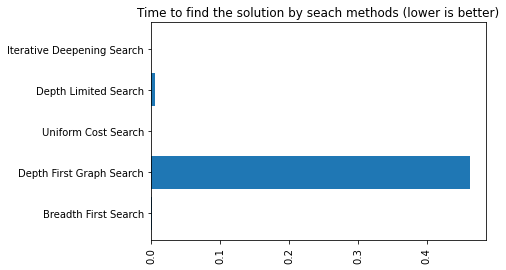

In [10]:
import matplotlib.pyplot as plt

searchMethods = ['Breadth First Search', 'Depth First Graph Search', 'Uniform Cost Search', 'Depth Limited Search', 'Iterative Deepening Search']
timeToExecute = [end_time_bfs,end_time_dfs,end_time_ucs,end_time_dls,end_time_ids]

plt.barh(searchMethods,timeToExecute)
plt.xticks(rotation=90)
plt.title('Time to find the solution by seach methods (lower is better)')
plt.show()

Now, we present the total number of clicks on the board made by each search method until solve the problem.

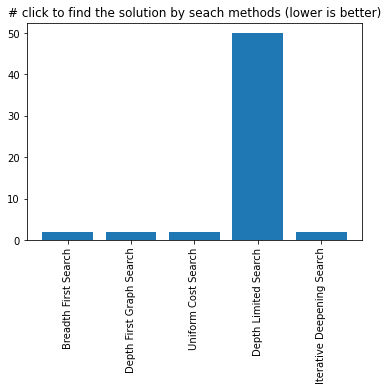

In [11]:
searchMethods = ['Breadth First Search', 'Depth First Graph Search', 'Uniform Cost Search', 'Depth Limited Search', 'Iterative Deepening Search']

goalBFS = breadth_first_search(problem)
# goalDFS = depth_first_graph_search(problem)
# goalUCS = uniform_cost_search(problem)
# goalDLS = depth_limited_search(problem)
# goalIDS = iterative_deepening_search(problem)

numberOfClicks = [
        len(goalBFS.solution()),
        len(goalDFS.solution()),
        len(goalUCS.solution()),
        len(goalDLS.solution()),
        len(goalIDS.solution())
    ]

plt.bar(searchMethods,numberOfClicks)
plt.xticks(rotation=90)
plt.title('# click to find the solution by seach methods (lower is better)')
plt.show()

Finally, these graphs represents how the number of balls on the board was changing at every click.

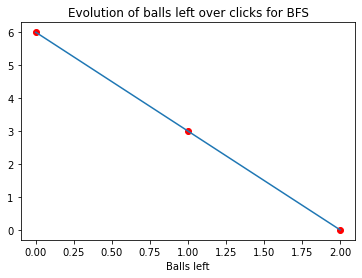

In [12]:
import numpy as np

# BFS
ballsLeftBFS = []
for i in range(len(goalBFS.solution())):
    ballsLeftBFS.append(len(goalBFS.path()[i].state))
ballsLeftBFS.append(0)

clicksBFS = np.arange(0,len(goalBFS.path()), 1)

plt.xlabel('Click number')
plt.xlabel('Balls left')
plt.title('Evolution of balls left over clicks for BFS')
plt.plot(clicksBFS, ballsLeftBFS)
plt.scatter(clicksBFS, ballsLeftBFS, c='r')

# plt.xlabel('Click number')
# plt.xlabel('Balls left')
# plt.title('Evolution of balls left over clicks')
# plt.plot(clicks, ballsLeft)
# plt.scatter(clicks, ballsLeft, c='r')

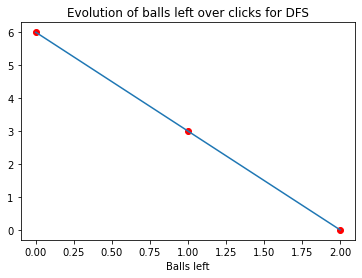

In [13]:
# DFS
ballsLeftDFS = []
for i in range(len(goalDFS.solution())):
    ballsLeftDFS.append(len(goalDFS.path()[i].state))
ballsLeftDFS.append(0)

clicksDFS = np.arange(0,len(goalDFS.path()), 1)

plt.xlabel('Click number')
plt.xlabel('Balls left')
plt.title('Evolution of balls left over clicks for DFS')
plt.plot(clicksDFS, ballsLeftDFS)
plt.scatter(clicksDFS, ballsLeftDFS, c='r')

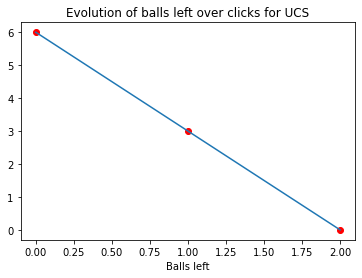

In [14]:
# UCS
ballsLeftUCS = []
for i in range(len(goalUCS.solution())):
    ballsLeftUCS.append(len(goalUCS.path()[i].state))
ballsLeftUCS.append(0)

clicksUCS = np.arange(0,len(goalUCS.path()), 1)

plt.xlabel('Click number')
plt.xlabel('Balls left')
plt.title('Evolution of balls left over clicks for UCS')
plt.plot(clicksUCS, ballsLeftUCS)
plt.scatter(clicksUCS, ballsLeftUCS, c='r')

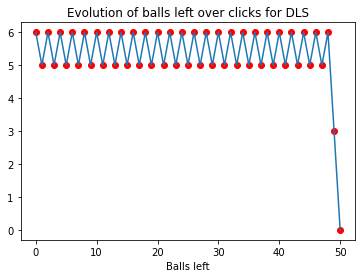

In [15]:
# DLS
ballsLeftDLS = []
for i in range(len(goalDLS.solution())):
    ballsLeftDLS.append(len(goalDLS.path()[i].state))
ballsLeftDLS.append(0)

clicksDLS = np.arange(0,len(goalDLS.path()), 1)

plt.xlabel('Click number')
plt.xlabel('Balls left')
plt.title('Evolution of balls left over clicks for DLS')
plt.plot(clicksDLS, ballsLeftDLS)
plt.scatter(clicksDLS, ballsLeftDLS, c='r')

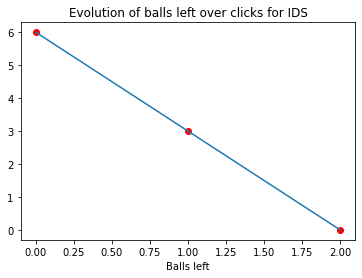

In [16]:
# DLS
ballsLeftIDS = []
for i in range(len(goalIDS.solution())):
    ballsLeftIDS.append(len(goalIDS.path()[i].state))
ballsLeftIDS.append(0)

clicksIDS = np.arange(0,len(goalIDS.path()), 1)

plt.xlabel('Click number')
plt.xlabel('Balls left')
plt.title('Evolution of balls left over clicks for IDS')
plt.plot(clicksIDS, ballsLeftIDS)
plt.scatter(clicksIDS, ballsLeftIDS, c='r')

# Test 2
In this test we use a more bigger board and added even more balls. The results are presented as follows:

In [ ]:
initial_state = tuple([(0,2),(0,4),(1,0),(1,3),(1,5),(2,1),(2,4),(3,0),(3,2),(3,4),(4,3),(4,5),(5,0),(5,2),(5,4),])
size = 6

# Conclusions:
<ul>
    <li><b>Could all the search methods solve the problem?</b></li> All the search algorithms can reach the desired goal, as long as we give them enough time to perform all the needed calculations in the case of BFS, and DFS.
    <li><b>How efficient they were?</b></li> Some of them even looked that they would never reach the goal state, for example, BFS and DFS require much more time to execute big problems than Uniform Cost Search, and even Depth Limited Search could not have ended if it had not been for the limit of 50. But despite of the problems in time and space of Breadth First Search and Uniform Cost Search, those method could find a solution in a few click on the board, while the Depth First Search has the worst time to find the solution and the worst number of clicks on the board until found the solution. Overall, DFS is the worst method in this kind of problem.
    <li><b>Was it difficult to program the Problem Solving Agent?</b></li> Nope, the only problem was to understand on how represent our states and try to capture that abstract idea inside the logic of the program.
    <li><b>Which search method overperforms the others?</b></li> The most optimal method was unvariably Uniform Cost Search, and Iterative Deepening Search. It not only determined the correct solution the fastest, but also reached the correct solution in the least amount of clicks. While the amount of clicks was the same for almost all the methods (With one extreme exception, in the form fo DLS), the part that gave the most optimal solution was determined in operating time. UCS and IDS reached a solution in the least amount of time in this case, while other methods, like DFS reached the correct solution, in an absurd amount of time compared to the others.
</ul>

In [27]:
environment = CleanupPuzzleEnvironment(11, 11)

# initial_state = [(0,3), (1,2), (1,4), (2,3), (3,7), (4,6), (4,3), (5,2), (5,4), (6,3), (5,9), (6,8), (6,9), (7,8), (7,10), (8,0), (8,5), (8,9), (9,1), (9,4), (9,6), (10,0), (10,5)]
# size = 11

initial_state = [(0,3), (1,2), (1,4), (2,3), (3,7), (4,6), (4,3), (5,2), (5,4), (6,3), (5,9), (6,8), (6,9), (7,8), (7,10), (8,0), (8,5), (8,9), (9,1), (9,4), (9,6), (10,0), (10,5)]

for s in initial_state:
    ball = Ball()
    environment.add_thing(ball, s)

print(environment)

,,,,,,,,,,
,,,,,,,,,,
,,,,,,,,,,
,,,,,,,,,,
,,,,,,,,,,
,,,,,,,,,,
,,,,,,,,,,
,,,,,,,,,,
,,,,,,,,,,
,,,,,,,,,,
,,,,,,,,,,
